In [1]:
import netCDF4 as nc
import scipy 
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load marineHeatWaves definition module
import marineHeatWaves as mhw
import dask
from xmhw.xmhw import threshold, detect
from datetime import date

import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
import hashlib
import matplotlib.colors as mcolors

In [48]:
input_location = 'Maria Island'

In [49]:
df_location = pd.read_csv('/g/data/v45/js5018/kelpdata/er_atrc_site_v2.csv')
input_lat = df_location.latitude[df_location.location == input_location].mean()
input_lon = df_location.longitude[df_location.location == input_location].mean()

## Find mhws and temperatures in each location

In [51]:
def summer_mhw_metric(input_location):
    infile = '/g/data/v45/js5018/sst/OBIS_kelp_sst.nc'    #  '/g/data/v45/js5018/sst/sst_keylocation/sst.' + name_dic[input_location] + '.noaaoisst.nc'

    ds = xr.open_dataset(infile).sel(
        time = slice('1991-01-01','2024-12-31')).sel(
        lat = slice(input_lat-0.25, input_lat+0.25), lon = slice(input_lon-0.25, input_lon+0.25)).squeeze('zlev', drop=True).mean(dim=("lat", "lon"))
    ds_summer = ds.sel(time=ds.sst.time.dt.month.isin([12,1,2,3,4]))
    
    date = np.array(ds_summer.time,dtype='datetime64[ns]')
    df = pd.DataFrame(date, columns=['date']) 
    df['doy'] = df['date'].dt.dayofyear
    df['temp'] = pd.DataFrame(ds_summer.sst.values)
    t = ds.time.values
    sst = ds.sst.values
    clim = threshold(ds.sst, climatologyPeriod=[1991, 2020]) # threshold and climatology
    maxthresh = clim.seas.max().values 
    
#     ## ========================= definded MHW events =================================
#     mhw = detect(ds.sst, clim.thresh, clim.seas)
#     df_mhw_events = mhw.to_dataframe().reset_index() #.intensity_max[mhw['time_peak'].dt.month.isin([1,2,3,4,12])]
#     df_mhw_events = df_mhw_events[['time_peak', 'intensity_max']]

#     # # Merge the two DataFrames on the 'doy' column
#     merged_df = pd.merge(df, df_mhw_events, left_on='date', right_on = 'time_peak', how='left')
#     # merged_df = merged_df.fillna(0)
    
#     summer_mhw_metrix = merged_df[['intensity_max']].set_index(merged_df.date)
#     summer_mhw_metrix.columns = ['mhwmax_inten']  ## 
#     # get mean summer temp and sum of summer intense
#     summer_mhw_metrix = summer_mhw_metrix.resample('AS-DEC').agg({'mhwmax_inten': 'mean'})
#     ## ================================ end ========================================================
    
    # Convert the xarray DataArray to a DataFrame
    climatology_df = clim.to_dataframe().reset_index()

    # Merge the two DataFrames on the 'doy' column
    merged_df = pd.merge(df, climatology_df, on='doy', how='left')  # 'left' to keep all records in the original DataFrame

    # add the dhd column, only keep positive intense values as our dhd
    merged_df['dhd50'] = (merged_df.temp - maxthresh).where((merged_df.temp - maxthresh)>0, 0)  
    merged_df['max_inten'] = merged_df.temp - maxthresh   ### intensity relative to different climatology values
    
    summer_mhw_metrix = merged_df[['temp', 'dhd50', 'max_inten']].set_index(merged_df.date)
    summer_mhw_metrix.columns = ['summer_temp', 'summer_dhd50', 'summer_inten']
    # get mean summer temp and sum of summer intense
    summer_mhw_metrix = summer_mhw_metrix.resample('AS-DEC').agg({'summer_temp': 'mean', 'summer_dhd50': 'sum', 'summer_inten': 'max'})
    # add one year
    summer_mhw_metrix['survey_year'] = summer_mhw_metrix.index.year+1
    
    ## ============================= dt dt =========================================================
    df = df.set_index('date')
    dt = 10
    dTdt = pd.DataFrame()
    for i in df.index.year.unique()[0:-1]:
        ssti = df[(df.index.year == i) & (df.index.month > 11) | (df.index.year == i+1) & (df.index.month <5)]
        
        # calculate n-day jumping mean
        jmeani = ssti.resample('10D').mean()

        # calculate dT as difference between consecutive 10-day means
        dT = jmeani.diff(periods=1)
        dTdt = pd.concat([dTdt, dT/dt])  #.mean()
        dTdt = dTdt.dropna()

    summer_dtdt = dTdt.resample('AS-DEC').max()
    summer_dtdt = summer_dtdt.rename(columns={'temp': 'summer_dtdt'}) 
    summer_dtdt['survey_year'] = summer_dtdt.index.year + 1
    
    summer_mhw_metrix = summer_mhw_metrix.merge(summer_dtdt, how='inner', on='survey_year')
    
    return summer_mhw_metrix

In [52]:
# check the output metric df
summer_mhw_metrix = summer_mhw_metric(input_location).fillna(0)
summer_mhw_metrix #.head()

,summer_temp,summer_dhd50,summer_inten,survey_year,doy,summer_dtdt
0,16.120394,0.000000,-0.001156,1992,1.0,0.17315
1,16.243046,0.178844,0.178844,1993,1.0,0.10290
2,15.958278,0.000000,-0.241156,1994,1.0,0.08080
3,16.145893,4.116518,0.773844,1995,1.0,0.16010
4,15.009145,0.000000,-1.071156,1996,1.0,0.14485
5,15.392980,0.835381,0.438845,1997,1.0,0.11365
6,16.244801,2.497295,0.543844,1998,1.0,0.12685
7,16.673542,16.809193,1.133844,1999,1.0,0.11290
8,16.772367,4.716503,0.368845,2000,1.0,0.09410
9,17.430496,50.161449,1.473845,2001,1.0,0.09970


In [53]:
# check mhw events
mhw = detect(ds.sst, clim.thresh, clim.seas)
mhw

<xarray.Dataset>
Dimensions:                         (events: 65)
Coordinates:
  * events                          (events) float64 78.0 ... 1.212e+04
Data variables: (12/31)
    event                           (events) float64 78.0 ... 1.212e+04
    index_start                     (events) float64 78.0 ... 1.212e+04
    index_end                       (events) float64 82.0 ... 1.217e+04
    time_start                      (events) datetime64[ns] 1991-03-20T12:00:...
    time_end                        (events) datetime64[ns] 1991-03-24T12:00:...
    time_peak                       (events) datetime64[ns] 1991-03-23T12:00:...
    ...                              ...
    intensity_var_relThresh         (events) float64 0.2263 0.128 ... 0.1635
    intensity_var_abs               (events) float32 0.2119 0.1344 ... 0.7045
    category                        (events) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    duration                        (events) float64 5.0 15.0 7.0 ... 109.0 51.0
    rate_onset                      (events) float64 0.2583 0.2301 ... 0.0225
    rate_decline                    (events) float64 0.3508 0.03543 ... 0.02529
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2024-10-16: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [ ]:
n_events = len(mhw.events)
print(n_events)
t_peak = mhw['time_peak']
t_peak.dt.month

In [ ]:
ev = np.argmax(mhw['intensity_max'].values)# Find largest event
ev


### kelp change all data

#### Site and year selection first

In [54]:
def get_site_year(input_location):
    df_site_kelp = pd.read_csv("/g/data/v45/js5018/kelpdata/er_3pop_site_v2.csv") 
    df_site_kelp = df_site_kelp[df_site_kelp.location == input_location]
    # Sort values
    df_site_kelp = df_site_kelp.sort_values(by=['site_name', 'survey_year'])
    # Convert to datetime format
    df_site_kelp['survey_datetime'] = pd.to_datetime(df_site_kelp['survey_year'].astype(str) + '-01-01')
    
    # Group by site_name and calculate rolling differences
    df_site_kelp['survey_change'] = df_site_kelp.groupby('site_name')['survey_mean'].diff()

    ### Jurien mask >3 rather 4, as we do not want the diff between 2009 and 2013;
    ### Jervis mask >5;  Maria mask > 2
    if input_location == 'Maria Island':
        mask = df_site_kelp.groupby('site_name')['survey_year'].diff() > 2
    elif input_location == 'Jervis Bay':
        mask = df_site_kelp.groupby('site_name')['survey_year'].diff() > 5
    else:
        mask = df_site_kelp.groupby('site_name')['survey_year'].diff() > 3
        
    df_site_kelp.loc[mask, 'survey_change'] = np.nan
    # Group the data by site_name and count the number of records for each site
    site_counts = df_site_kelp.groupby('site_name').size()
    # Identify sites with only one record
    single_survey_sites = site_counts[site_counts == 1].index

    df_site_kelp = df_site_kelp[~df_site_kelp['site_name'].isin(single_survey_sites)]
    if input_location != 'Maria Island':
        # Group by site_name and get the number of unique years for each site
        site_years = df_site_kelp.groupby('site_name')['survey_year'].nunique()
        if input_location == 'Jervis Bay':
            consistent_sites = site_years[site_years >= 10].index.tolist()
        else:    
            consistent_sites = site_years[site_years >= 7].index.tolist()
        # Now, filter the main dataframe to keep only these sites
        df_site_kelp = df_site_kelp[df_site_kelp['site_name'].isin(consistent_sites)]
    
    return df_site_kelp

In [55]:
df_site_kelp = get_site_year(input_location)
df_site_kelp

,location,site_code,site_name,survey_year,taxon,survey_mean,survey_datetime,survey_change
582,Maria Island,MIR-S7,Magistrates Point North,1992,Ecklonia radiata,29.8,1992-01-01,NaN
583,Maria Island,MIR-S7,Magistrates Point North,1995,Ecklonia radiata,39.2,1995-01-01,NaN
584,Maria Island,MIR-S7,Magistrates Point North,1996,Ecklonia radiata,39.4,1996-01-01,0.2
585,Maria Island,MIR-S7,Magistrates Point North,1997,Ecklonia radiata,41.8,1997-01-01,2.4
586,Maria Island,MIR-S7,Magistrates Point North,1998,Ecklonia radiata,30.9,1998-01-01,-10.9
...,...,...,...,...,...,...,...,...
497,Maria Island,MIR-S14,Spring Beach,2019,Ecklonia radiata,25.7,2019-01-01,7.2
498,Maria Island,MIR-S14,Spring Beach,2020,Ecklonia radiata,35.5,2020-01-01,9.8
499,Maria Island,MIR-S14,Spring Beach,2021,Ecklonia radiata,28.5,2021-01-01,-7.0
500,Maria Island,MIR-S14,Spring Beach,2022,Ecklonia radiata,26.5,2022-01-01,-2.0


#### Add summer mhw metrics in the df

In [56]:
# # Initialize a new column in df_site_kelp to store the computed max summer temperatures
# df_site_kelp['mhwmax_inten'] = np.nan

# for site in df_site_kelp.site_name.unique():
#     dfi = df_site_kelp[df_site_kelp.site_name == site]
    
#     for j in range(1, len(dfi.survey_year)):             # survey_year in dfi is not continuous, so
#         # find the max temp between the two survey years. (j-1)th is not just one-year before jth year , it is the previous survey year before jth survey year 
#         summer_temp_max = summer_mhw_metrix.mhwmax_inten[summer_mhw_metrix.survey_year.isin(range(dfi.survey_year.iloc[j-1]+1, dfi.survey_year.iloc[j]+1))].max() 
        
#         # Update the summer_temp_max value in the corresponding row of df_site_kelp
#         mask = (df_site_kelp.site_name == site) & (df_site_kelp.survey_year == dfi.survey_year.iloc[j])
#         df_site_kelp.loc[mask, 'mhwmax_inten'] = summer_temp_max

# # Now df_site_kelp has an additional column 'summer_temp_max' with the computed max summer temperatures
# df_site_kelp.dropna()

In [57]:
# Initialize a new column in df_site_kelp to store the computed max summer temperatures
df_site_kelp['summer_temp_max'] = np.nan
df_site_kelp['summer_dhd50_max'] = np.nan
df_site_kelp['summer_inten_max'] = np.nan
df_site_kelp['summer_dtdt_max'] = np.nan

for site in df_site_kelp.site_name.unique():
    dfi = df_site_kelp[df_site_kelp.site_name == site]
    
    for j in range(1, len(dfi.survey_year)):             # survey_year in dfi is not continuous, so
        # find the max temp between the two survey years. (j-1)th is not just one-year before jth year , it is the previous survey year before jth survey year 
        summer_temp_max = summer_mhw_metrix.summer_temp[summer_mhw_metrix.survey_year.isin(range(dfi.survey_year.iloc[j-1]+1, dfi.survey_year.iloc[j]+1))].max() 
        summer_dhd50_max = summer_mhw_metrix.summer_dhd50[summer_mhw_metrix.survey_year.isin(range(dfi.survey_year.iloc[j-1]+1, dfi.survey_year.iloc[j]+1))].max()
        summer_inten_max = summer_mhw_metrix.summer_inten[summer_mhw_metrix.survey_year.isin(range(dfi.survey_year.iloc[j-1]+1, dfi.survey_year.iloc[j]+1))].max()
        summer_dtdt_max = summer_mhw_metrix.summer_dtdt[summer_mhw_metrix.survey_year.isin(range(dfi.survey_year.iloc[j-1]+1, dfi.survey_year.iloc[j]+1))].max() 
        
        # Update the summer_temp_max value in the corresponding row of df_site_kelp
        mask = (df_site_kelp.site_name == site) & (df_site_kelp.survey_year == dfi.survey_year.iloc[j])
        df_site_kelp.loc[mask, 'summer_temp_max'] = summer_temp_max
        df_site_kelp.loc[mask, 'summer_dhd50_max'] = summer_dhd50_max
        df_site_kelp.loc[mask, 'summer_inten_max'] = summer_inten_max
        df_site_kelp.loc[mask, 'summer_dtdt_max'] = summer_dtdt_max

# Now df_site_kelp has an additional column 'summer_temp_max' with the computed max summer temperatures
df_site_kelp = df_site_kelp.dropna()
df_site_kelp

,location,site_code,site_name,survey_year,taxon,survey_mean,survey_datetime,survey_change,summer_temp_max,summer_dhd50_max,summer_inten_max,summer_dtdt_max
584,Maria Island,MIR-S7,Magistrates Point North,1996,Ecklonia radiata,39.4,1996-01-01,0.2,15.009145,0.000000,-1.071156,0.14485
585,Maria Island,MIR-S7,Magistrates Point North,1997,Ecklonia radiata,41.8,1997-01-01,2.4,15.392980,0.835381,0.438845,0.11365
586,Maria Island,MIR-S7,Magistrates Point North,1998,Ecklonia radiata,30.9,1998-01-01,-10.9,16.244801,2.497295,0.543844,0.12685
587,Maria Island,MIR-S7,Magistrates Point North,1999,Ecklonia radiata,30.4,1999-01-01,-0.5,16.673542,16.809193,1.133844,0.11290
588,Maria Island,MIR-S7,Magistrates Point North,2000,Ecklonia radiata,37.1,2000-01-01,6.7,16.772367,4.716503,0.368845,0.09410
...,...,...,...,...,...,...,...,...,...,...,...,...
497,Maria Island,MIR-S14,Spring Beach,2019,Ecklonia radiata,25.7,2019-01-01,7.2,17.337252,39.683754,1.463844,0.08220
498,Maria Island,MIR-S14,Spring Beach,2020,Ecklonia radiata,35.5,2020-01-01,9.8,16.440788,0.584604,0.143845,0.13855
499,Maria Island,MIR-S14,Spring Beach,2021,Ecklonia radiata,28.5,2021-01-01,-7.0,17.481266,58.863720,1.373844,0.14530
500,Maria Island,MIR-S14,Spring Beach,2022,Ecklonia radiata,26.5,2022-01-01,-2.0,17.540331,55.521034,1.578844,0.10695


In [58]:
# filter out anomalous sites and years for particular locations
if input_location == 'Jurien':
    df_site_kelp = df_site_kelp[(df_site_kelp.survey_year != 2013) & (df_site_kelp.site_name != 'Kearn Reef')]  # Jurien
elif input_location == 'Jervis Bay':
    # Jervis
    df_site_kelp = df_site_kelp[(df_site_kelp.site_name != 'Flat Rock') & (df_site_kelp.site_name != 'GREEN POINT (GREEN ISLAND)') & (df_site_kelp.site_name != 'Tapalla Point (Husky Reef)')]
    df_site_kelp = df_site_kelp[df_site_kelp.site_name != 'Drum and Drumstick']   
else:
    print(input_location)

Maria Island


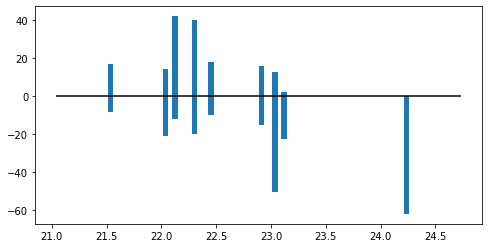

In [44]:

fig, ax = plt.subplots(figsize = (8,4))
plt.bar(df_site_kelp.summer_temp_max, df_site_kelp.survey_change, width= 0.05)
ax.hlines(0, min(df_site_kelp.summer_temp_max)-0.5, max(df_site_kelp.summer_temp_max)+0.5, linestyles='-', colors='k')

# plt.ylabel('Cover change (%)')
# plt.xlabel('temperature (°C)')

# fig, ax = plt.subplots(figsize = (8,4))
# plt.bar(df_site_kelp.summer_dhd50_max, df_site_kelp.survey_change, width= 1)
# ax.hlines(0, min(df_site_kelp.summer_dhd50_max)-0.5, max(df_site_kelp.summer_dhd50_max)+0.5, linestyles='-', colors='k')

# plt.ylabel('Cover change (%)')

# fig, ax = plt.subplots(figsize = (8,4))
# plt.bar(df_site_kelp.summer_inten_max, df_site_kelp.survey_change, width= 0.1)
# ax.hlines(0, min(df_site_kelp.summer_inten_max)-0.5, max(df_site_kelp.summer_inten_max)+0.5, linestyles='-', colors='k')

# plt.ylabel('Cover change (%)')

In [155]:
# df_site_kelp.to_csv('/g/data/v45/js5018/chapter2/4pop_change_rawdata.csv', index=False)
df_existing = pd.read_csv('/g/data/v45/js5018/chapter2/4pop_change_rawdata.csv')
df_combined = df_existing.append(df_site_kelp, ignore_index=True)
df_combined.to_csv('/g/data/v45/js5018/chapter2/4pop_change_rawdata.csv', index=False)

#### remove 2011 data in Jurien

In [13]:
df_site_kelp = df_site_kelp.dropna()
df_site_kelp = df_site_kelp[df_site_kelp.survey_year < 2012]
df_site_kelp

,location,site_code,site_name,survey_year,taxon,survey_mean,survey_datetime,survey_change,summer_temp_max,summer_dhd50_max,summer_inten_max,summer_dtdt_max
376,Jurien,JMP-S5,Escape Island,2000,Ecklonia radiata,56.400000,2000-01-01,-13.000000,23.119671,62.666290,2.524355,0.094667
377,Jurien,JMP-S5,Escape Island,2003,Ecklonia radiata,46.200000,2003-01-01,-10.200000,22.454592,36.348991,1.824356,0.134800
378,Jurien,JMP-S5,Escape Island,2004,Ecklonia radiata,60.900000,2004-01-01,14.700000,21.535767,4.514576,1.114355,0.133367
379,Jurien,JMP-S5,Escape Island,2006,Ecklonia radiata,56.400000,2006-01-01,-4.500000,22.040197,19.356289,2.054354,0.166900
326,Jurien,JMP-S25,Fishermans Island,2000,Ecklonia radiata,3.200000,2000-01-01,1.866667,23.119671,62.666290,2.524355,0.094667
327,Jurien,JMP-S25,Fishermans Island,2003,Ecklonia radiata,2.400000,2003-01-01,-0.800000,22.454592,36.348991,1.824356,0.134800
328,Jurien,JMP-S25,Fishermans Island,2004,Ecklonia radiata,7.600000,2004-01-01,5.200000,21.535767,4.514576,1.114355,0.133367
329,Jurien,JMP-S25,Fishermans Island,2006,Ecklonia radiata,4.800000,2006-01-01,-2.800000,22.040197,19.356289,2.054354,0.166900
330,Jurien,JMP-S25,Fishermans Island,2009,Ecklonia radiata,3.800000,2009-01-01,-1.000000,22.912500,81.909157,2.654356,0.151733
406,Jurien,JMP-S8,Fishermans Island 1,2004,Ecklonia radiata,13.600000,2004-01-01,3.400000,21.535767,4.514576,1.114355,0.133367


In [14]:
df_site_kelp.to_csv('/g/data/v45/js5018/chapter2/2wapop_change_before2011_v2.csv', index = False)

#### Fitting a model for dhd!

In [93]:
# Add a constant (i.e., bias or intercept) to the independent variable
x = df_site_kelp.summer_dhd50_max

# This is your dependent variable
y = df_site_kelp.survey_change

In [94]:
model = smf.mixedlm("survey_change ~ summer_dhd50_max", df_site_kelp, groups = df_site_kelp["site_name"])
fit = model.fit(method='powell')

# Predict y-values for the regression line using the range of 'summer_temp' values
x_vals = np.linspace(df_site_kelp['summer_dhd50_max'].min(), df_site_kelp['summer_dhd50_max'].max(), 1000)
# Adjust x-values range
# x_vals = np.linspace(0, 80, 200) 
y_vals = fit.predict(pd.DataFrame({"summer_dhd50_max": x_vals}))

# Get the summary
fit.summary()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: survey_change
No. Observations: 217     Method:             REML         
No. Groups:       9       Scale:              120.7967     
Min. group size:  22      Log-Likelihood:     -829.4869    
Max. group size:  26      Converged:          Yes          
Mean group size:  24.1                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.488    0.983  0.496 0.620 -1.439  2.415
summer_dhd50_max -0.019    0.019 -0.974 0.330 -0.056  0.019
Group Var         0.000                                    
===========================================================

"""

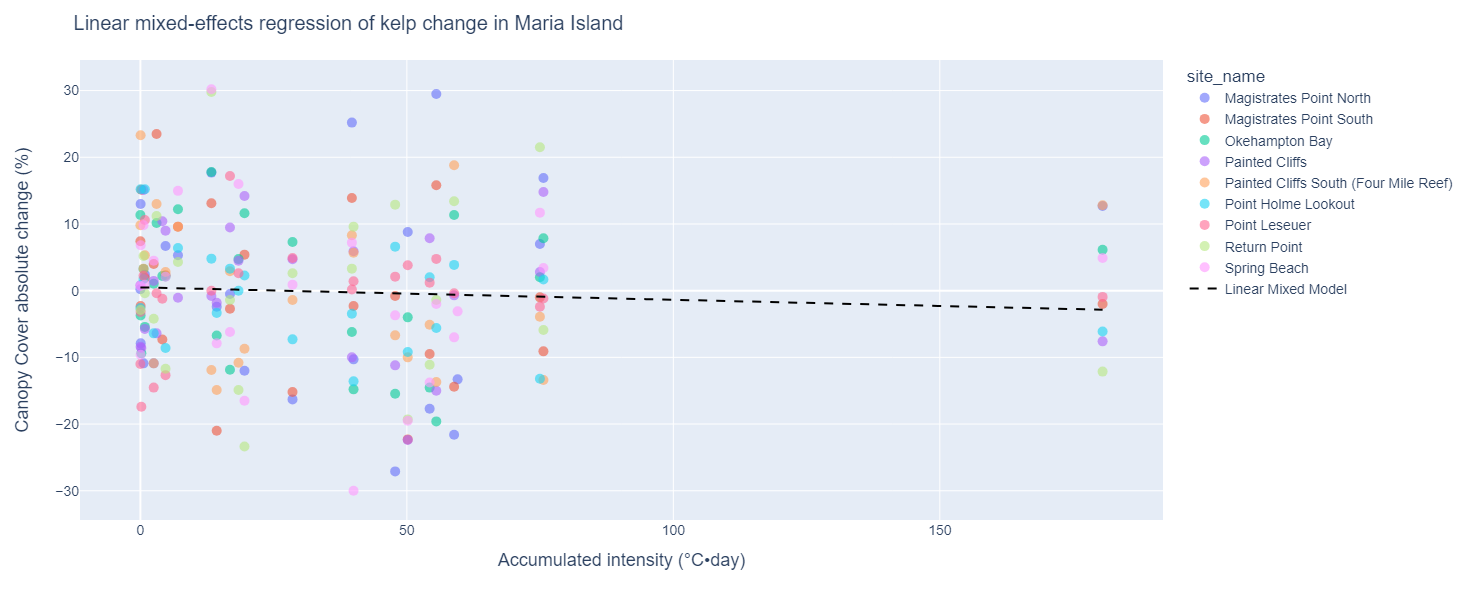

In [95]:
fig = px.scatter(x='summer_dhd50_max', y='survey_change', data_frame = df_site_kelp, color='site_name', opacity=0.6)
fig.update_traces(marker_size=10 ,selector=dict(mode='markers'))

# Add the regression line to the scatter plot
fig.add_traces(go.Scatter(x = x_vals, y = y_vals, mode='lines', name='Linear Mixed Model', line=dict(color='black', dash='dash')))

# fig.add_trace(go.Scatter(x=x_vals, y=y_vals_linear, mode='lines', name="Linear Regression", marker_color="black"))

fig.update_layout(autosize=False, width=800, height=600, 
                  title=f"Linear mixed-effects regression of kelp change in {input_location}", xaxis_title= u'Accumulated intensity (\u00B0C•day)', yaxis_title='Canopy Cover absolute change (%)', 
                  title_font=dict(family="Abadi, Arial, sans-serif", size=20), xaxis_title_font=dict(family="Abadi, Arial, sans-serif", size=18), yaxis_title_font=dict(family="Abadi, Arial, sans-serif", size=18),
                  font=dict(family="Abadi, Arial, sans-serif", size=14))
fig.show()

#### Confidence interval for dhd!

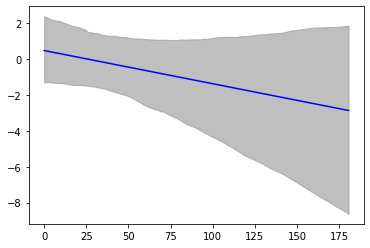

In [96]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Number of bootstrap samples
n_bootstrap = 1000

# Placeholders for our predictions
bootstrap_preds = np.zeros((n_bootstrap, len(x_vals)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    for i in range(n_bootstrap):
        # Resample the dataset with replacement
        resampled = df_site_kelp.sample(n=len(df_site_kelp), replace=True)
        
        # Refit the mixed-effects model to the resampled data
        model = smf.mixedlm("survey_change ~ summer_dhd50_max", resampled, groups=resampled["site_name"])
        fit = model.fit(method='powell', maxiter=1000, disp=0)  # increased maxiter
        
        # Predict using the new model
        y_vals_bootstrap = fit.predict(pd.DataFrame({"summer_dhd50_max": x_vals}))
        bootstrap_preds[i, :] = y_vals_bootstrap

# Calculate the 2.5th and 97.5th percentiles for the predictions
lower_bound = np.percentile(bootstrap_preds, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_preds, 97.5, axis=0)

# Now you can plot your predictions and the confidence intervals
plt.plot(x_vals, y_vals, 'b-')  # blue line for the prediction
plt.fill_between(x_vals, lower_bound, upper_bound, color='gray', alpha=0.5)  # gray fill between bounds for the confidence interval

In [97]:
summer_dhd70_max = summer_dhd50_max
df_model = pd.DataFrame({"location": input_location,
                         "summer_dhd50_max": x_vals,
                         "predicted_change": y_vals,
                         'lower_bound': lower_bound, 
                         'upper_bound': upper_bound
                        })
# df_model.to_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/dhdmodel_change_relationship_v2.csv', index=False)
df_existing = pd.read_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/dhdmodel_change_relationship_v2.csv')
df_combined = df_existing.append(df_model, ignore_index=True)

In [98]:
# Save the combined data back to CSV
df_combined.to_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/dhdmodel_change_relationship_v2.csv', index=False)

#### Fitting a model for summer_temp!

In [59]:
# Add a constant (i.e., bias or intercept) to the independent variable
x = df_site_kelp.summer_temp_max

# This is your dependent variable
y = df_site_kelp.survey_change

In [60]:
model = smf.mixedlm("survey_change ~ summer_temp_max", df_site_kelp, groups = df_site_kelp["site_name"])
fit = model.fit(method='powell')

# Predict y-values for the regression line using the range of 'summer_temp' values
x_vals = np.linspace(df_site_kelp['summer_temp_max'].min(), df_site_kelp['summer_temp_max'].max(), 1000)
# Adjust x-values range
# x_vals = np.linspace(21.2, 24.5, 100) 
y_vals = fit.predict(pd.DataFrame({"summer_temp_max": x_vals}))

# Get the summary
fit.summary()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: survey_change
No. Observations: 217     Method:             REML         
No. Groups:       9       Scale:              119.5606     
Min. group size:  22      Log-Likelihood:     -824.4400    
Max. group size:  26      Converged:          Yes          
Mean group size:  24.1                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        29.204   16.467  1.773 0.076 -3.071 61.479
summer_temp_max  -1.739    0.975 -1.784 0.074 -3.649  0.172
Group Var         0.000                                    
===========================================================

"""

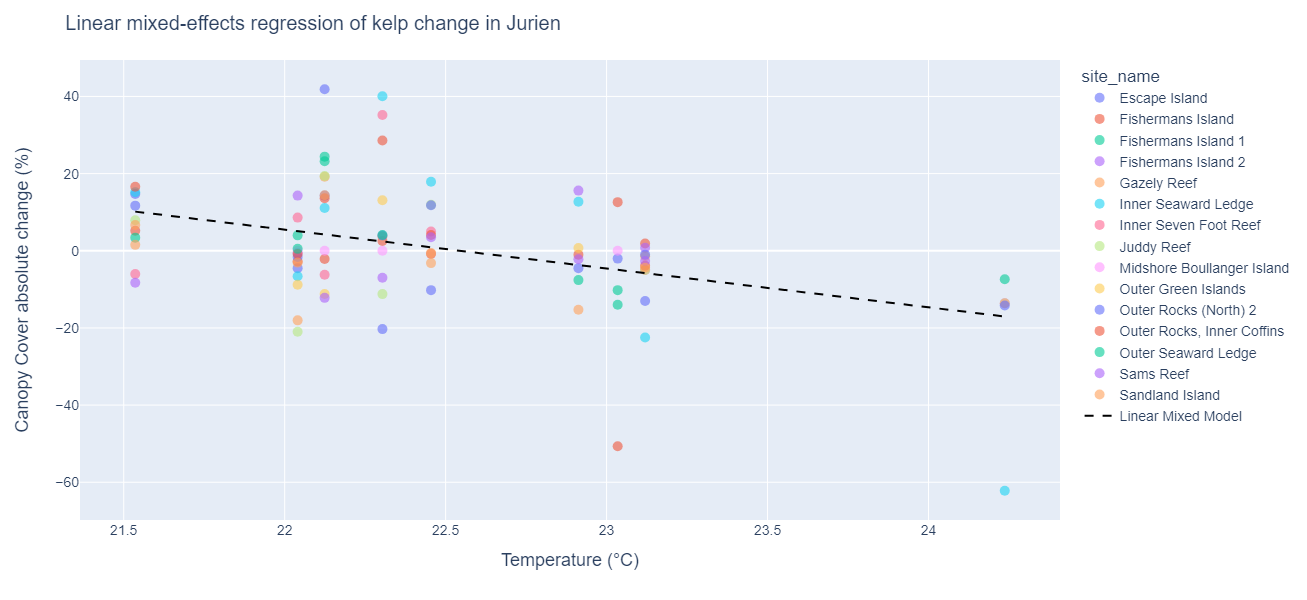

In [47]:
fig = px.scatter(x='summer_temp_max', y='survey_change', data_frame = df_site_kelp, color='site_name', opacity=0.6)
fig.update_traces(marker_size=10 ,selector=dict(mode='markers'))

# Add the regression line to the scatter plot
fig.add_traces(go.Scatter(x = x_vals, y = y_vals, mode='lines', name='Linear Mixed Model', line=dict(color='black', dash='dash')))

# fig.add_trace(go.Scatter(x=x_vals, y=y_vals_linear, mode='lines', name="Linear Regression", marker_color="black"))

fig.update_layout(autosize=False, width=800, height=600, 
                  title=f"Linear mixed-effects regression of kelp change in {input_location}", xaxis_title= u'Temperature (\u00B0C)', yaxis_title='Canopy Cover absolute change (%)', 
                  title_font=dict(family="Abadi, Arial, sans-serif", size=20), xaxis_title_font=dict(family="Abadi, Arial, sans-serif", size=18), yaxis_title_font=dict(family="Abadi, Arial, sans-serif", size=18),
                  font=dict(family="Abadi, Arial, sans-serif", size=14))
fig.show()

#### confidence interval for summer_temp!

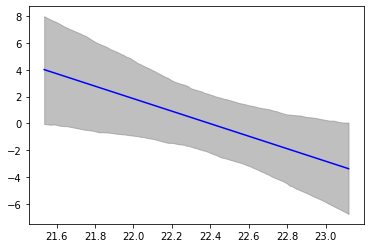

In [18]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Number of bootstrap samples
n_bootstrap = 1000

# Placeholders for our predictions
bootstrap_preds = np.zeros((n_bootstrap, len(x_vals)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    for i in range(n_bootstrap):
        # Resample the dataset with replacement
        resampled = df_site_kelp.sample(n=len(df_site_kelp), replace=True)
        
        # Refit the mixed-effects model to the resampled data
        model = smf.mixedlm("survey_change ~ summer_temp_max", resampled, groups=resampled["site_name"])
        fit = model.fit(method='powell', maxiter=1000, disp=0)  # increased maxiter
        
        # Predict using the new model
        y_vals_bootstrap = fit.predict(pd.DataFrame({"summer_temp_max": x_vals}))
        bootstrap_preds[i, :] = y_vals_bootstrap

# Calculate the 2.5th and 97.5th percentiles for the predictions
lower_bound = np.percentile(bootstrap_preds, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_preds, 97.5, axis=0)

# Now you can plot your predictions and the confidence intervals
plt.plot(x_vals, y_vals, 'b-')  # blue line for the prediction
plt.fill_between(x_vals, lower_bound, upper_bound, color='gray', alpha=0.5)  # gray fill between bounds for the confidence interval

In [19]:
df_model = pd.DataFrame({"location": input_location,
                         "summer_temp_max": x_vals,
                         "predicted_change": y_vals,
                         'lower_bound': lower_bound, 
                         'upper_bound': upper_bound
                        })
df_model.to_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/jurien_change_relation2011_v2.csv', index=False)
# df_existing = pd.read_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/model_change_relationship_v2.csv')
# df_combined = df_existing.append(df_model, ignore_index=True)

In [104]:
# Save the combined data back to CSV
df_combined.to_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/model_change_relationship_v2.csv', index=False)

#### Fitting model for max intensity!

In [105]:
# Add a constant (i.e., bias or intercept) to the independent variable
x = df_site_kelp.summer_inten_max

# This is your dependent variable
y = df_site_kelp.summer_inten_max

In [106]:
model = smf.mixedlm("survey_change ~ summer_inten_max", df_site_kelp, groups = df_site_kelp["site_name"])
fit = model.fit(method='powell')

# Predict y-values for the regression line using the range of 'summer_temp' values
x_vals = np.linspace(df_site_kelp['summer_inten_max'].min(), df_site_kelp['summer_inten_max'].max(), 1000)
# Adjust x-values range
# x_vals = np.linspace(0, 4.5, 50) 
y_vals = fit.predict(pd.DataFrame({"summer_inten_max": x_vals}))

# Get the summary
fit.summary()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: survey_change
No. Observations: 217     Method:             REML         
No. Groups:       9       Scale:              120.6497     
Min. group size:  22      Log-Likelihood:     -825.5666    
Max. group size:  26      Converged:          Yes          
Mean group size:  24.1                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.991    1.266  0.783 0.434 -1.491  3.473
summer_inten_max -0.926    0.841 -1.101 0.271 -2.575  0.723
Group Var         0.000                                    
===========================================================

"""

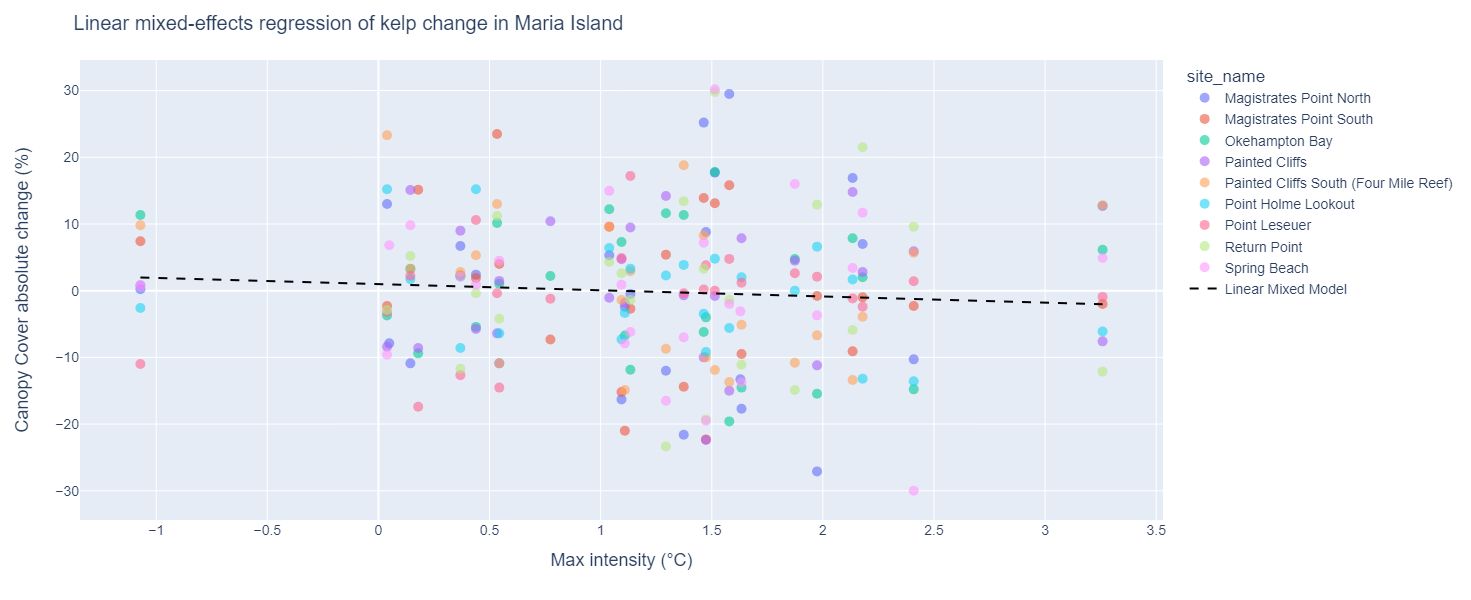

In [107]:
fig = px.scatter(x='summer_inten_max', y='survey_change', data_frame = df_site_kelp, color='site_name', opacity=0.6)
fig.update_traces(marker_size=10 ,selector=dict(mode='markers'))

# Add the regression line to the scatter plot
fig.add_traces(go.Scatter(x = x_vals, y = y_vals, mode='lines', name='Linear Mixed Model', line=dict(color='black', dash='dash')))

# fig.add_trace(go.Scatter(x=x_vals, y=y_vals_linear, mode='lines', name="Linear Regression", marker_color="black"))

fig.update_layout(autosize=False, width=800, height=600, 
                  title=f"Linear mixed-effects regression of kelp change in {input_location}", xaxis_title= u'Max intensity (\u00B0C)', yaxis_title='Canopy Cover absolute change (%)', 
                  title_font=dict(family="Abadi, Arial, sans-serif", size=20), xaxis_title_font=dict(family="Abadi, Arial, sans-serif", size=18), yaxis_title_font=dict(family="Abadi, Arial, sans-serif", size=18),
                  font=dict(family="Abadi, Arial, sans-serif", size=14))
fig.show()

#### Confidence interval for intensity!

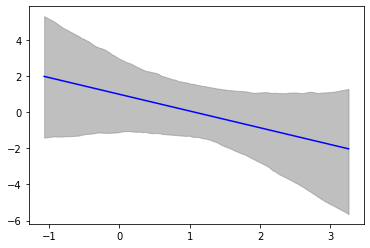

In [108]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Number of bootstrap samples
n_bootstrap = 1000

# Placeholders for our predictions
bootstrap_preds = np.zeros((n_bootstrap, len(x_vals)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    for i in range(n_bootstrap):
        # Resample the dataset with replacement
        resampled = df_site_kelp.sample(n=len(df_site_kelp), replace=True)
        
        # Refit the mixed-effects model to the resampled data
        model = smf.mixedlm("survey_change ~ summer_inten_max", resampled, groups=resampled["site_name"])
        fit = model.fit(method='powell', maxiter=1000, disp=0)  # increased maxiter
        
        # Predict using the new model
        y_vals_bootstrap = fit.predict(pd.DataFrame({"summer_inten_max": x_vals}))
        bootstrap_preds[i, :] = y_vals_bootstrap

# Calculate the 2.5th and 97.5th percentiles for the predictions
lower_bound = np.percentile(bootstrap_preds, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_preds, 97.5, axis=0)

# Now you can plot your predictions and the confidence intervals
plt.plot(x_vals, y_vals, 'b-')  # blue line for the prediction
plt.fill_between(x_vals, lower_bound, upper_bound, color='gray', alpha=0.5)  # gray fill between bounds for the confidence interval

In [109]:
df_model = pd.DataFrame({"location": input_location,
                         "summer_inten_max": x_vals,
                         "predicted_change": y_vals,
                         'lower_bound': lower_bound, 
                         'upper_bound': upper_bound
                        })
# df_model.to_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/inten_max_model_change_relationship_v2.csv', index=False)
df_existing = pd.read_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/inten_max_model_change_relationship_v2.csv')
df_combined = df_existing.append(df_model, ignore_index=True)

In [110]:
# Save the combined data back to CSV
df_combined.to_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/inten_max_model_change_relationship_v2.csv', index=False)

#### Fitting a model for dtdt!

In [111]:
# Add a constant (i.e., bias or intercept) to the independent variable
x = df_site_kelp.summer_dtdt_max

# This is your dependent variable
y = df_site_kelp.survey_change

In [112]:
model = smf.mixedlm("survey_change ~ summer_dtdt_max", df_site_kelp, groups = df_site_kelp["site_name"])
fit = model.fit(method='powell')

# Predict y-values for the regression line using the range of 'summer_temp' values
x_vals = np.linspace(df_site_kelp['summer_dtdt_max'].min(), df_site_kelp['summer_dtdt_max'].max(), 100)
# Adjust x-values range
# x_vals = np.linspace(0.5, 2.5, 50) 
y_vals = fit.predict(pd.DataFrame({"summer_dtdt_max": x_vals}))

# Get the summary
fit.summary()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:             MixedLM Dependent Variable: survey_change
No. Observations:  217     Method:             REML         
No. Groups:        9       Scale:              121.0559     
Min. group size:   22      Log-Likelihood:     -822.3797    
Max. group size:   26      Converged:          Yes          
Mean group size:   24.1                                     
------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------
Intercept         2.445    3.777  0.647 0.517  -4.958  9.848
summer_dtdt_max -20.418   29.291 -0.697 0.486 -77.828 36.992
Group Var         0.000                                     
============================================================

"""

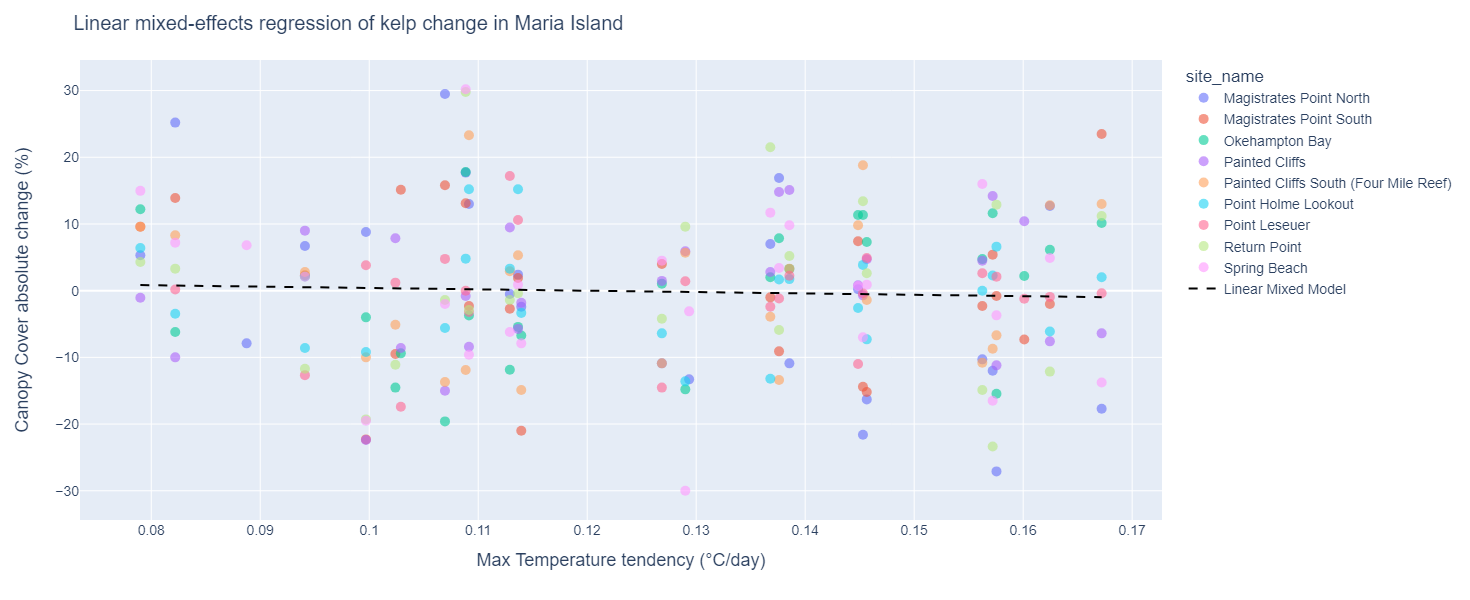

In [113]:
fig = px.scatter(x='summer_dtdt_max', y='survey_change', data_frame = df_site_kelp, color='site_name', opacity=0.6)
fig.update_traces(marker_size=10 ,selector=dict(mode='markers'))

# Add the regression line to the scatter plot
fig.add_traces(go.Scatter(x = x_vals, y = y_vals, mode='lines', name='Linear Mixed Model', line=dict(color='black', dash='dash')))

# fig.add_trace(go.Scatter(x=x_vals, y=y_vals_linear, mode='lines', name="Linear Regression", marker_color="black"))

fig.update_layout(autosize=False, width=800, height=600, 
                  title = f"Linear mixed-effects regression of kelp change in {input_location}", xaxis_title= u'Max Temperature tendency (\u00B0C/day)', yaxis_title='Canopy Cover absolute change (%)', 
                  title_font=dict(family="Abadi, Arial, sans-serif", size=20), xaxis_title_font=dict(family="Abadi, Arial, sans-serif", size=18), yaxis_title_font=dict(family="Abadi, Arial, sans-serif", size=18),
                  font=dict(family="Abadi, Arial, sans-serif", size=14))
fig.show()

#### Confidence interval for dtdt!

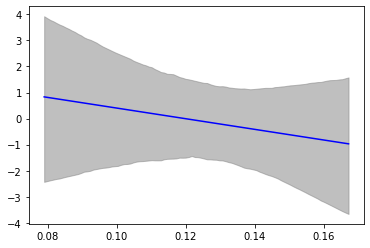

In [114]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Number of bootstrap samples
n_bootstrap = 1000

# Placeholders for our predictions
bootstrap_preds = np.zeros((n_bootstrap, len(x_vals)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    for i in range(n_bootstrap):
        # Resample the dataset with replacement
        resampled = df_site_kelp.sample(n=len(df_site_kelp), replace=True)
        
        # Refit the mixed-effects model to the resampled data
        model = smf.mixedlm("survey_change ~ summer_dtdt_max", resampled, groups=resampled["site_name"])
        fit = model.fit(method='powell', maxiter=1000, disp=0)  # increased maxiter
        
        # Predict using the new model
        y_vals_bootstrap = fit.predict(pd.DataFrame({"summer_dtdt_max": x_vals}))
        bootstrap_preds[i, :] = y_vals_bootstrap

# Calculate the 2.5th and 97.5th percentiles for the predictions
lower_bound = np.percentile(bootstrap_preds, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_preds, 97.5, axis=0)

# Now you can plot your predictions and the confidence intervals
plt.plot(x_vals, y_vals, 'b-')  # blue line for the prediction
plt.fill_between(x_vals, lower_bound, upper_bound, color='gray', alpha=0.5)  # gray fill between bounds for the confidence interval

In [115]:
df_model = pd.DataFrame({"location": input_location,
                         "summer_dtdt_max": x_vals,
                         "predicted_change": y_vals,
                         'lower_bound': lower_bound, 
                         'upper_bound': upper_bound
                        })
# df_model.to_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/dtdtmodel_change_relationship_v2.csv', index=False)
df_existing = pd.read_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/dtdtmodel_change_relationship_v2.csv')
df_combined = df_existing.append(df_model, ignore_index=True)

In [116]:
# Save the combined data back to CSV
df_combined.to_csv('/g/data/v45/js5018/chapter2/model_3pop_figure/dtdtmodel_change_relationship_v2.csv', index=False)

In [ ]:
import plotly.io as pio

# Save as HTML
pio.write_html(fig, file='/g/data/v45/js5018/kelptempdata/maria_realised_adaptation.html')

In [ ]:
import seaborn as sns

In [ ]:
sns.set_style("ticks")
fig = sns.lmplot(x='summer_temp_max', y='survey_change', hue = 'site_name', data = df_site_kelp, 
                 height=8, ci=95, 
                 palette='bright', scatter_kws=dict(alpha=0.4))
fig.set(xlabel = u'Temperature (\u00B0C)', ylabel = "Canopy Cover (%)")
pass

In [ ]:
fig = px.scatter(x='summer_temp_max', y='survey_change', data_frame = df_site_kelp, color='site_name',
                 trendline='ols', 
                 color_discrete_sequence = px.colors.qualitative.G10, opacity=0.6)

fig.update_traces(marker_size=8, selector=dict(mode='markers'))
fig.update_layout(autosize=False, width=900, height=550, 
                  xaxis_title = u'Temperature (\u00B0C)', yaxis_title="Canopy Cover (%)",
                  font=dict(family="Abadi, Arial, sans-serif"))